In [1]:
import matplotlib
import matplotlib.pylab as plt
import string
import os
from subprocess import call
import glob2 as glob
import numpy as np
import cv2
from scipy.ndimage import imread
from scipy.stats import pearsonr
from skimage.feature import hog
from skimage.transform import resize
from PIL import Image, ImageFont, ImageDraw, ImageOps
import peakutils
%matplotlib inline

In [2]:
def get_bounding_box(image, threshold=1):
    mask = image < threshold
    if False not in mask:
        return image
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    return image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

In [3]:
# create 25x25 patches representing each letter in the alphabet
alphabet = 'abcdefghijlmnopqrstuvxz '
letters = []
for letter in alphabet:
    im = Image.new("RGB", (25, 25))
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype("fonts/giordano/giordano-webfont.ttf", 24)
    draw.text((8, 4), letter, font=font)
    data = np.array(im.convert('L'))
    #data = get_bounding_box(data)
    data = resize(data, (25, 25))
    letters.append(data)
letters = np.array(letters, dtype=np.float32)

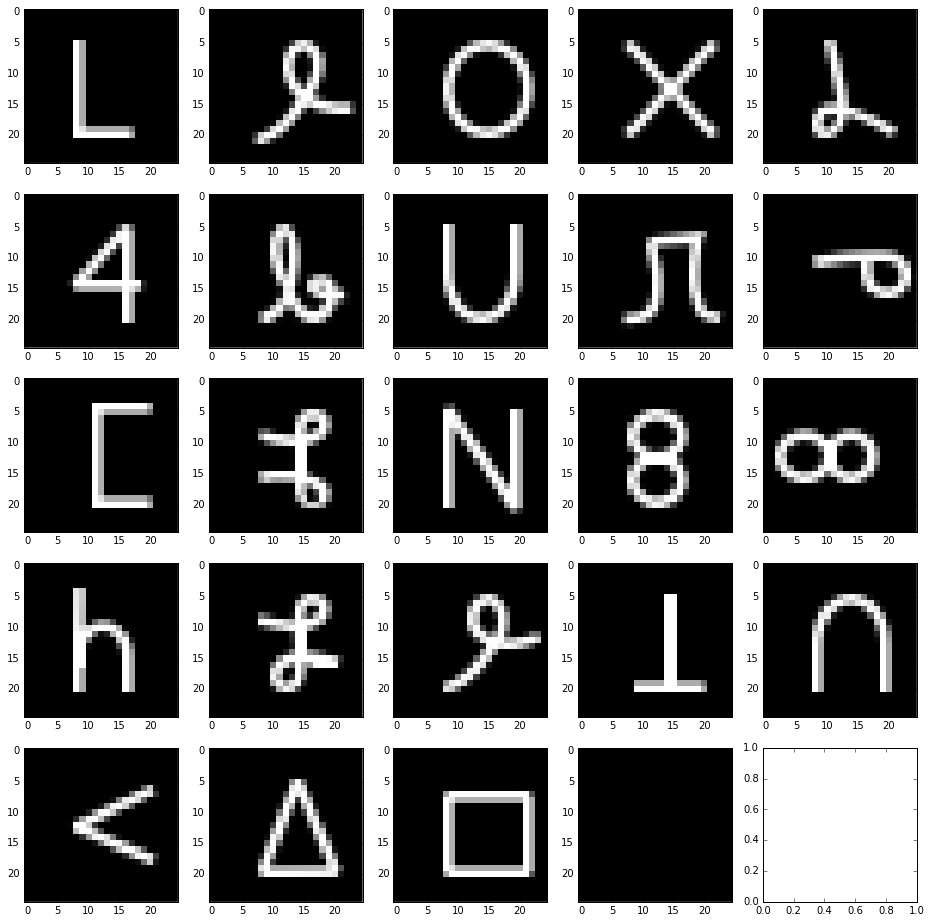

In [4]:
# plot alphabet
dim = int(np.sqrt(len(alphabet)) + 1)
fig, axes = plt.subplots(dim, dim, figsize=(16, 16))
axes = axes.flatten()
for i in range(len(letters)):
    axes[i].imshow(letters[i], aspect='auto', interpolation='None', cmap='gray')

In [5]:
# extract hog features for feature matching
letters_hog = [hog(letter, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualise=False) 
               for letter in letters]

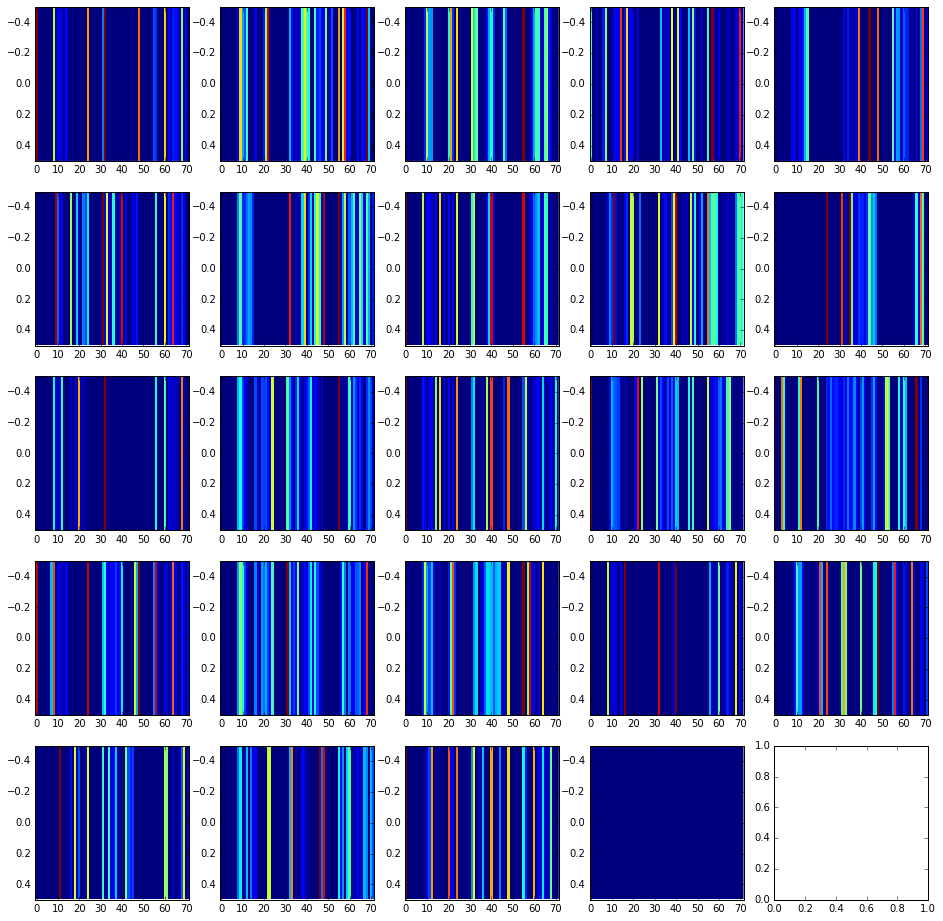

In [6]:
# plot alphabet in hog features
dim = int(np.sqrt(len(alphabet)) + 1)
fig, axes = plt.subplots(dim, dim, figsize=(16, 16))
axes = axes.flatten()
for i in range(len(letters_hog)):
    axes[i].imshow(letters_hog[i].reshape((1, -1)), aspect='auto', interpolation='None')

In [7]:
# load text data
filepath = 'img/optimized/imagem1.jpeg'
img = Image.open(filepath) # open colour image
data = np.array(ImageOps.invert(img.convert('L')), dtype=np.float32)
data /= data.max()

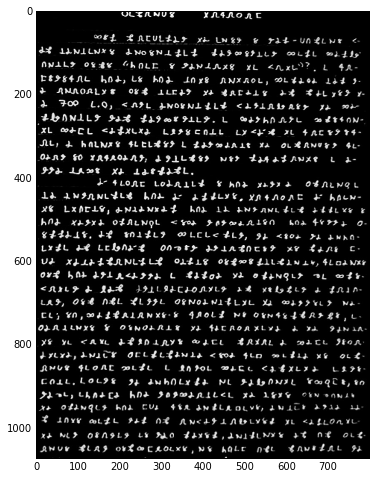

In [8]:
# plot text data
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='gray')

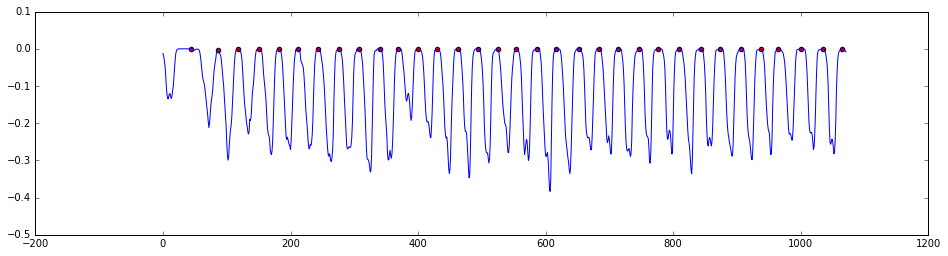

In [9]:
# find and plot beginning and end of lines 
avg_black_per_row = -1*np.mean(data, axis=1)
peaks_row = peakutils.indexes(avg_black_per_row, thres=0.9, min_dist=10)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(avg_black_per_row)
ax.scatter(peaks_row, avg_black_per_row[peaks_row], c='red')

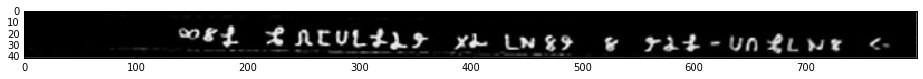

In [39]:
# confirm that line looks correct
plt.figure(figsize=(16, 16))
plt.imshow(data[peaks_row[0]:peaks_row[1], :], cmap='gray', interpolation='none')

In [48]:
# find beginning and end of words given each line
char_ids_per_line = []
for i in range(len([peaks_row])):
    line = data[peaks_row[i]:peaks_row[i+1]]
    avg_black_per_col = -1*np.mean(line.T, axis=1)
    #peaks_col = find_peaks_cwt(avg_black_per_col, np.arange(1, 25))
    peaks_col = peakutils.indexes(avg_black_per_col, min_dist=10)
    char_ids_per_line.append(peaks_col)

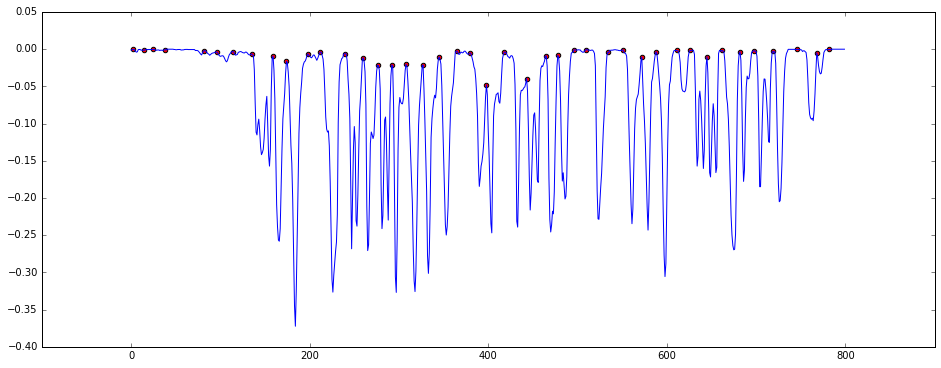

In [50]:
# visualize begining and end of words
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(avg_black_per_col)
ax.scatter(peaks_col, avg_black_per_col[peaks_col], c='red')

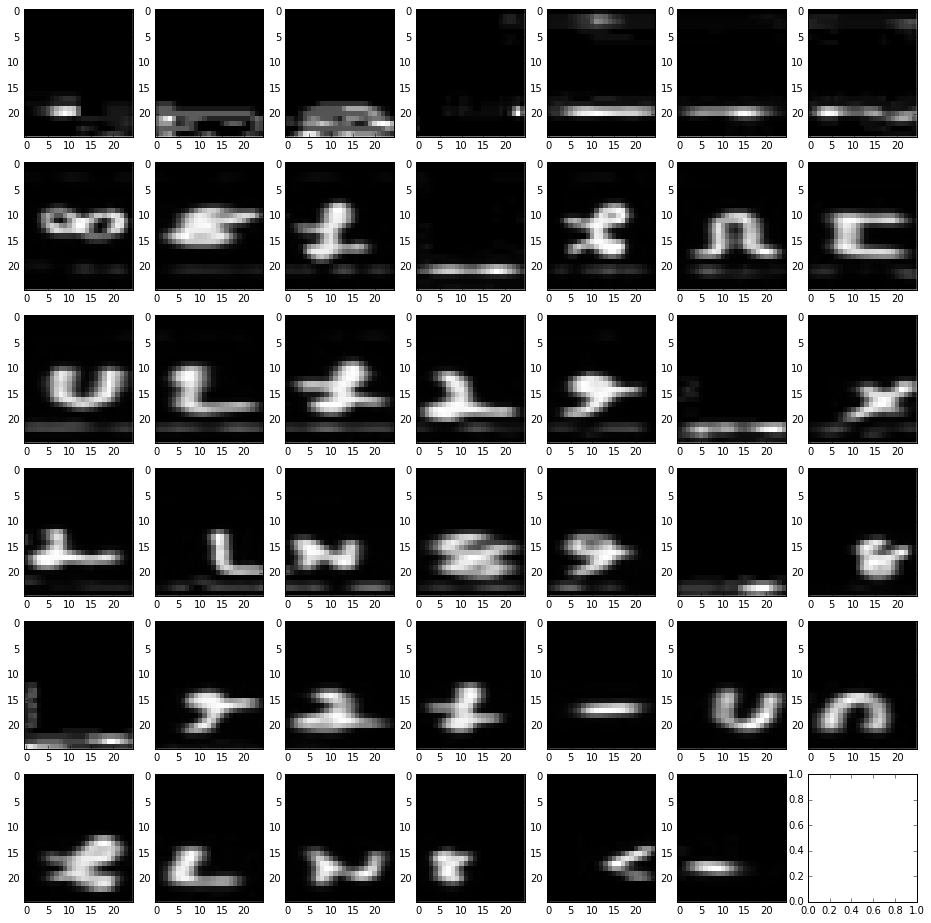

In [56]:
# visualize segmented patches given last line
fig, axes = plt.subplots(6, int(len(peaks_col)/6), figsize=(16, 16))
axes = axes.flatten()
for i in range(len(peaks_col)-1):
    patch = line[:, peaks_col[i]:peaks_col[i+1]]
    # binarize it with thresholding
    #patch = get_bounding_box(patch, 0.02)
    patch = resize(patch, (25, 25), mode='constant')
    axes[i].imshow(patch, aspect='auto', interpolation='None', cmap='gray')

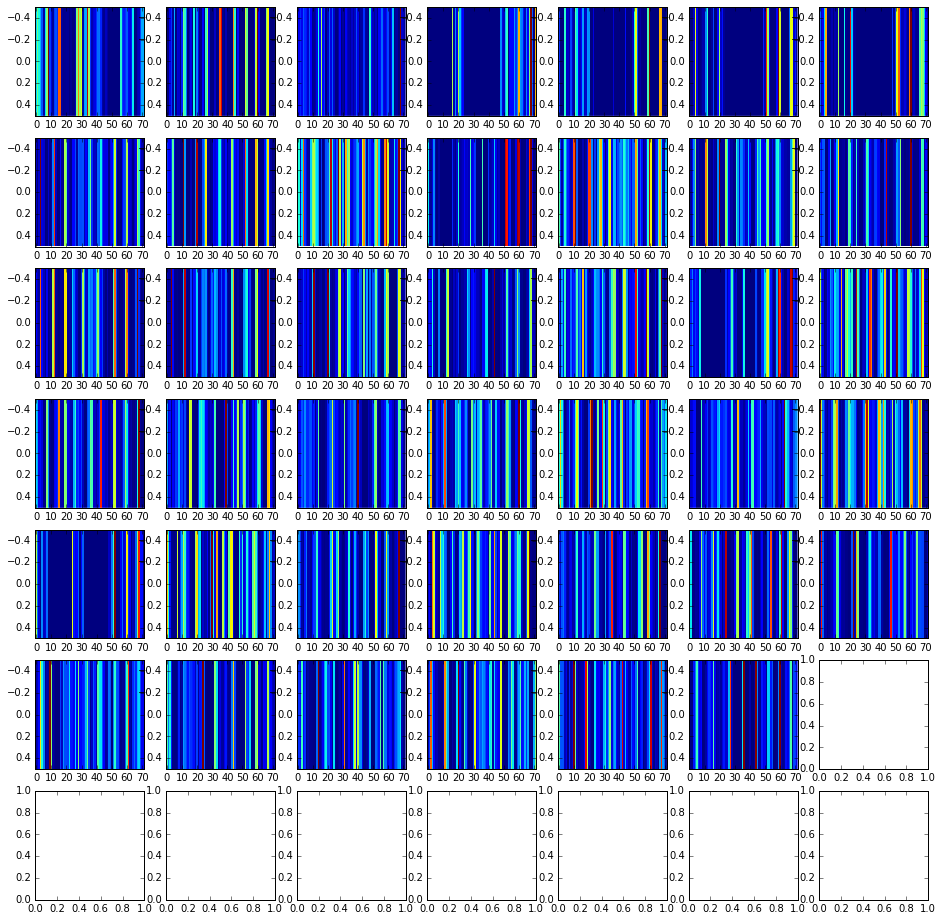

In [57]:
# plot hog features from all patches
patches_hog = []
for i in range(len(peaks_col)-1):
    patch = line[:, peaks_col[i]:peaks_col[i+1]]
    patch = get_bounding_box(patch, 0.01)
    patch = resize(patch, (25, 25))    
    patch_hog = hog(patch, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualise=False)
    patches_hog.append(patch_hog)

dim = int(np.sqrt(len(patches_hog)) + 1)
fig, axes = plt.subplots(dim, dim, figsize=(16, 16))
axes = axes.flatten()
for i in range(len(patches_hog)):
    axes[i].imshow(patches_hog[i].reshape((1, -1)), aspect='auto', interpolation='None')

In [63]:
mse = lambda x, y: np.mean((x-y)**2)
corr = lambda x, y: pearsonr(x, y)[0]
transcription = []
for patch_hog in patches_hog:
    letter_id = np.argmin([mse(patch_hog, letter_hog) for letter_hog in letters_hog])
    transcription.append(alphabet[letter_id])

In [64]:
print transcription

[' ', ' ', ' ', ' ', ' ', ' ', ' ', 'p', 'p', 'b', ' ', ' ', 'i', 'r', 'p', 'p', 'i', 'e', 'j', ' ', ' ', 'r', 'b', 'r', 'p', 's', ' ', 'r', ' ', 'r', ' ', 'g', 'j', 'h', 'u', 'r', 'j', 'r', 'g', 'r', 'j']


In [75]:
patch_hog = patches_hog[8]

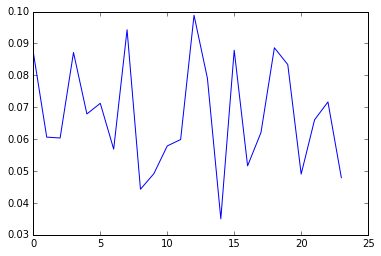

In [76]:
plt.plot([mse(patch_hog, letter_hog) for letter_hog in letters_hog])

In [68]:
alphabet

'abcdefghijlmnopqrstuvxz '